# **Sky Rose Case Study**

This case study focuses on Skyrose Marketing Agency, where Cynthia Wright, VP of the beverage clients group, is exploring how to use Google Trends data to forecast consumer demand for three key products: white wine, whiskey, and craft beer. The goal is to smooth out workload peaks, improve team management, and deliver better results for clients by predicting seasonal demand patterns. Using time series analysis, the study examines search trend data to generate insights, build forecasts, and recommend strategies for optimizing marketing planning and resource allocation in 2026.

For the purpose of this analysis, we will narrow the scope to only **whiskey**, dropping the other products, and focus exclusively on forecasting its demand trends.

**Summary of Steps Performed:**

1.  **Data Loading and Preparation**
2.  **Exploratory Data Analysis (EDA)**
3.  **Baseline Forecasting Models**:
    *   **Naive Forecast**
    *   **Moving Average**
4.  **Exponential Smoothing Models**
    *   **Simple Exponential Smoothing (SES)**
    *   **Double Exponential Smoothing (DES)**
    *   **Triple Exponential Smoothing (TES)**
5.  **Model Evaluation**
6.  **Time Series Analysis**:  
*   **Check for stationarity**
*   **ACF & PACF**
7.  **ARMA Model**:
8.  **Interpretation of Model Performance Metrics**:
9. **Conclusion**
10. **Months having highest search volumes**
11. **2026 Forecast**

## **1. Data Loading & Preparation**

Loading the dataset from the specified CSV file into a pandas DataFrame and displaying the first few rows.

In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/Sky_rose_Dataset_Canada.csv')
df.head()

,Week,Whisky,White wine,Craft Beer
0,8/30/2020,40,22,7
1,9/6/2020,42,24,6
2,9/13/2020,50,20,6
3,9/20/2020,53,21,5
4,9/27/2020,41,20,6


In this step, we clean the data by removing the 'White wine' and 'Craft Beer' columns as they are not relevant to our 'Whisky' sales forecasting task. We also convert the 'Week' column to a datetime object to enable time-series analysis. The head of the updated DataFrame is displayed to show the changes.

In [9]:
df.drop(['White wine'], axis=1, inplace = True)
df.drop(['Craft Beer'], axis=1, inplace = True)
df['Week'] = pd.to_datetime(df['Week'])
df.head()

,Week,Whisky
0,2020-08-30,40
1,2020-09-06,42
2,2020-09-13,50
3,2020-09-20,53
4,2020-09-27,41


## **2. Exploratory Data Analysis**

Checking for missing values in each column of the DataFrame. The output shows that there are no missing values in either the 'Week' or 'Whisky' columns, which is good as it means we don't need to perform any imputation or removal of rows with missing data.

In [10]:
df.isnull().sum()

,0
Week,0
Whisky,0


Checking for duplicate rows in the DataFrame. The output shows that there are no duplicate rows, which is also good as it ensures the uniqueness of our data points.

In [11]:
df.duplicated().sum()

0

Generating descriptive statistics for the DataFrame, transposed for easier readability. It provides insights into the central tendency, dispersion, and shape of the 'Whisky' sales data, such as the count, mean, standard deviation, minimum, maximum, and quartile values. It also shows the range of the 'Week' column.

In [12]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Week,262,2023-03-01 12:00:00,2020-08-30 00:00:00,2021-11-29 18:00:00,2023-03-01 12:00:00,2024-05-31 06:00:00,2025-08-31 00:00:00,NaN
Whisky,262.0,51.053435,37.0,46.0,49.0,53.0,100.0,10.131937


Information about the DataFrame, including the column names, the number of non-null values in each column, and the data types of each column. This confirms that the 'Week' column is now a datetime object and the 'Whisky' column is an integer, and that there are no missing values.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Week    262 non-null    datetime64[ns]
 1   Whisky  262 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.2 KB


Generating three visualizations to explore the distribution and trend of 'Whisky' sales:
*   **Histogram**: Shows the frequency distribution of 'Whisky' sales, with a Kernel Density Estimate (KDE) overlay to show the smoothed distribution.
*   **Boxplot**: Displays the distribution of 'Whisky' sales through quartiles and highlights potential outliers.
*   **Scatter plot**: Plots 'Whisky' sales over time ('Week') to visualize any trends or seasonality in the data. The x-axis labels are rotated for better readability.

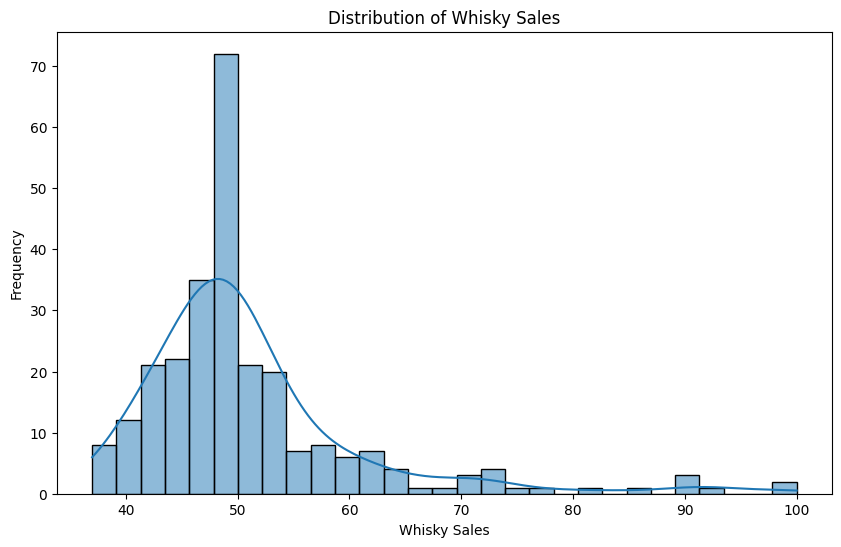

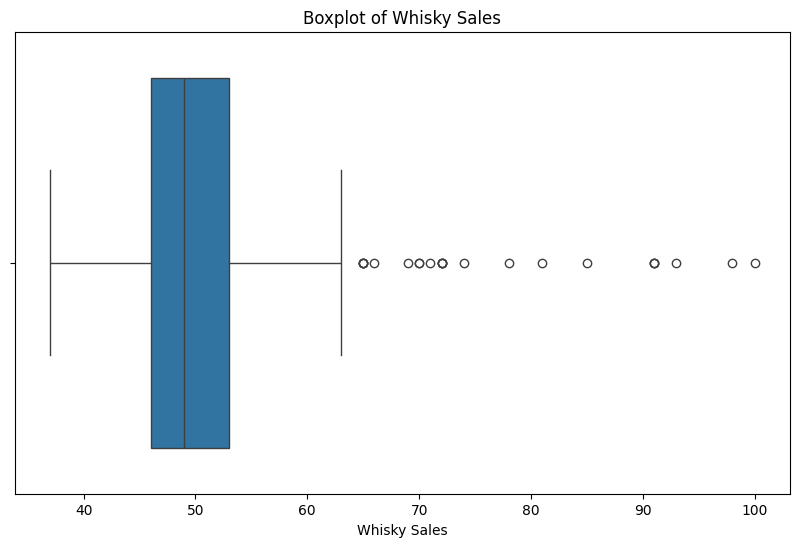

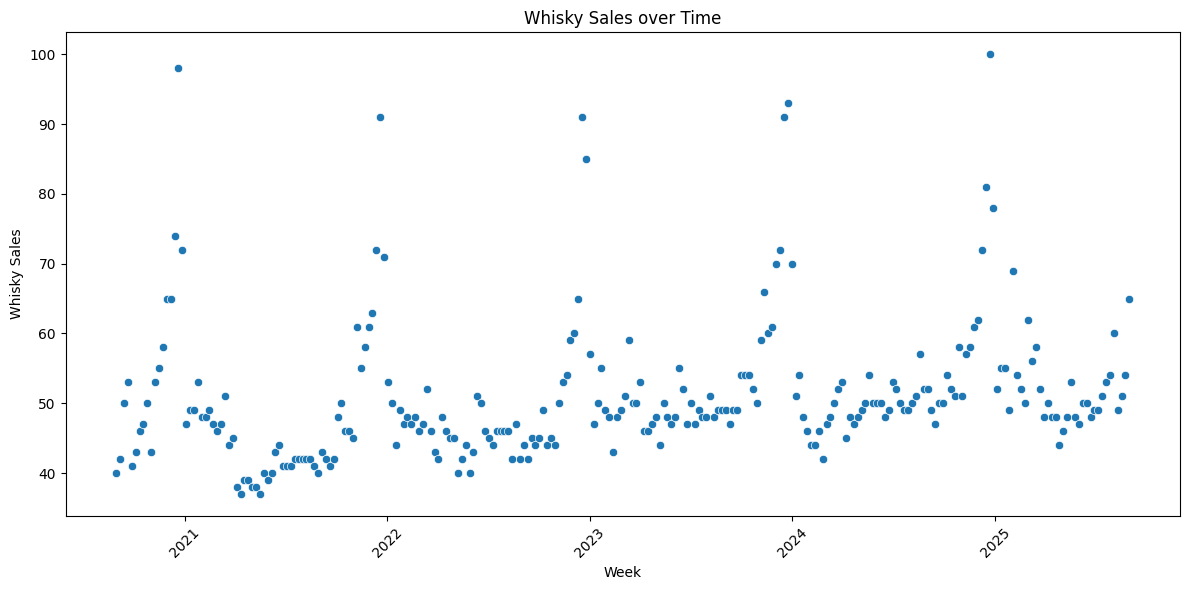

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Whisky', kde=True)
plt.title('Distribution of Whisky Sales')
plt.xlabel('Whisky Sales')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Whisky')
plt.title('Boxplot of Whisky Sales')
plt.xlabel('Whisky Sales')
plt.show()

# Scatter plot (assuming 'Week' is the x-axis for time-series)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Week', y='Whisky')
plt.title('Whisky Sales over Time')
plt.xlabel('Week')
plt.ylabel('Whisky Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **3. Baseline Forecasting Models**

**1. Naive Forecast Model**

Implementing the Naive Forecast model. The code creates a new column 'Whisky\_Naive\_Forecast' by shifting the 'Whisky' column by one row, so that the forecast for the current week is the actual sales value from the previous week. It then calculates and prints the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) to evaluate the performance of this simple model.

In [15]:
# Implement Naive Forecasting (using the last observed value as the forecast)
df['Whisky_Naive_Forecast'] = df['Whisky'].shift(1)

# Display the dataframe with the new naive forecast column
display(df.head())

# Calculate and print performance metrics for Naive Forecast (excluding the first row with NaN)
from sklearn.metrics import mean_squared_error
import numpy as np

df_eval_naive = df.dropna(subset=['Whisky_Naive_Forecast']).copy()

mse_naive = mean_squared_error(df_eval_naive['Whisky'], df_eval_naive['Whisky_Naive_Forecast'])
rmse_naive = np.sqrt(mse_naive)

# Avoid division by zero in MAPE calculation
df_eval_naive['MAPE_Error'] = np.abs((df_eval_naive['Whisky'] - df_eval_naive['Whisky_Naive_Forecast']) / df_eval_naive['Whisky'])
mape_naive = np.mean(df_eval_naive['MAPE_Error'][df_eval_naive['Whisky'] != 0]) * 100

print(f"\nMSE (Naive Forecast): {mse_naive}")
print(f"RMSE (Naive Forecast): {rmse_naive}")
print(f"MAPE (Naive Forecast): {mape_naive}%")

,Week,Whisky,Whisky_Naive_Forecast
0,2020-08-30,40,NaN
1,2020-09-06,42,40.0
2,2020-09-13,50,42.0
3,2020-09-20,53,50.0
4,2020-09-27,41,53.0



MSE (Naive Forecast): 45.59003831417625
RMSE (Naive Forecast): 6.752039566988351
MAPE (Naive Forecast): 7.494461571720541%


Visualizing the actual 'Whisky' sales against the Naive Forecast. The plot helps to visually assess how well the Naive Forecast tracks the actual sales data.

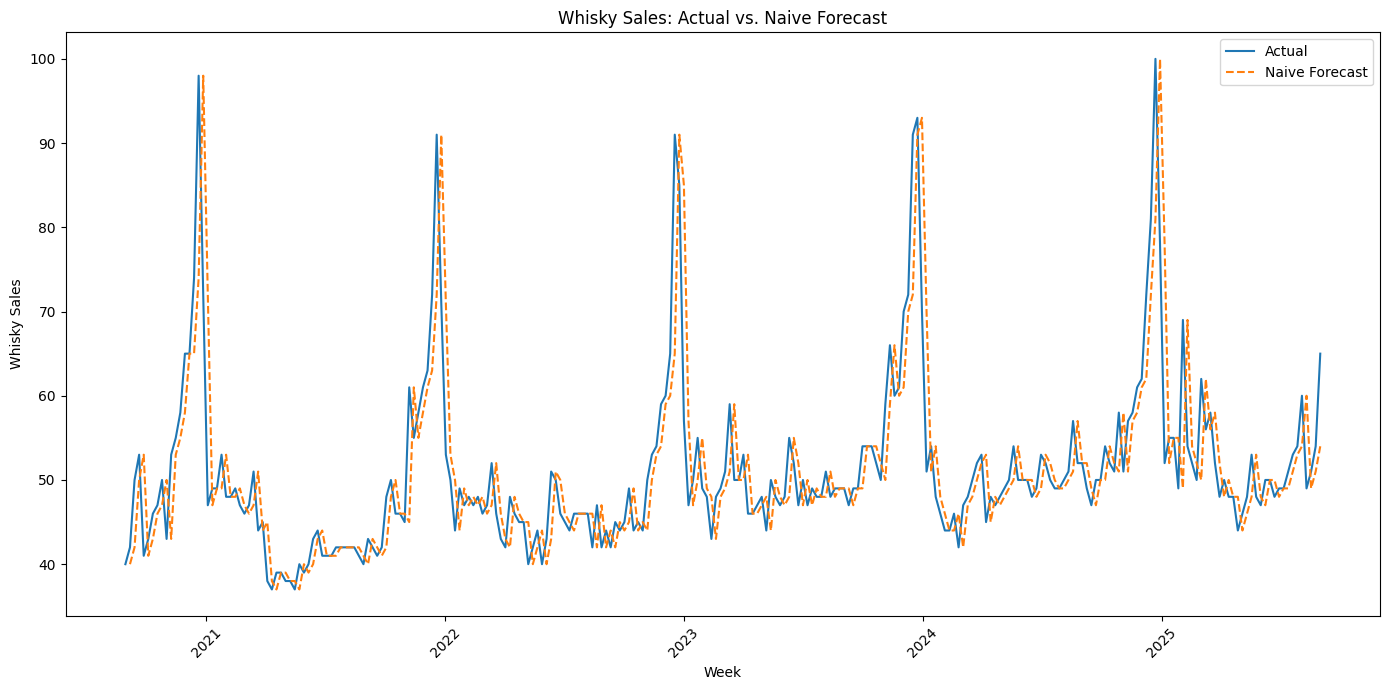

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['Whisky'], label='Actual')
plt.plot(df['Week'], df['Whisky_Naive_Forecast'], label='Naive Forecast', linestyle='--')
plt.title('Whisky Sales: Actual vs. Naive Forecast')
plt.xlabel('Week')
plt.ylabel('Whisky Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**2. Moving Average**

Calculating a 3-day moving average of the 'Whisky' sales and storing it in a new column 'Whisky\_Moving\_Average\_3Day'. A moving average smooths out short-term fluctuations and highlights longer-term trends. The head of the DataFrame is displayed to show the new column.

In [17]:
df['Whisky_Moving_Average_3Day'] = df['Whisky'].rolling(window=3).mean()
display(df.head())

,Week,Whisky,Whisky_Naive_Forecast,Whisky_Moving_Average_3Day
0,2020-08-30,40,NaN,NaN
1,2020-09-06,42,40.0,NaN
2,2020-09-13,50,42.0,44.000000
3,2020-09-20,53,50.0,48.333333
4,2020-09-27,41,53.0,48.000000


This code calculates and prints the MSE, RMSE, and MAPE for the 3-day moving average forecast. These metrics quantify the accuracy of the moving average model.

In [18]:
from sklearn.metrics import mean_squared_error

# Drop rows with NaN in the moving average column, as they cannot be used for error calculation
df_eval = df.dropna(subset=['Whisky_Moving_Average_3Day']).copy()

# Calculate MSE
mse_3day = mean_squared_error(df_eval['Whisky'], df_eval['Whisky_Moving_Average_3Day'])

# Calculate RMSE
rmse_3day = np.sqrt(mse_3day)

# Calculate MAPE
# Avoid division by zero in MAPE calculation
df_eval['MAPE_Error'] = np.abs((df_eval['Whisky'] - df_eval['Whisky_Moving_Average_3Day']) / df_eval['Whisky'])
mape_3day = np.mean(df_eval['MAPE_Error'][df_eval['Whisky'] != 0]) * 100

print(f"MSE: {mse_3day}")
print(f"RMSE: {rmse_3day}")
print(f"MAPE: {mape_3day}%")

MSE: 25.961538461538463
RMSE: 5.095246653650681
MAPE: 5.53106466857728%


Calculating a 7-day moving average of the 'Whisky' sales and storing it in a new column 'Whisky\_Moving\_Average\_7Day'. A longer window for the moving average provides more smoothing. The head of the DataFrame is displayed to show the new column.

In [19]:
df['Whisky_Moving_Average_7Day'] = df['Whisky'].rolling(window=7).mean()
display(df.head())

,Week,Whisky,Whisky_Naive_Forecast,Whisky_Moving_Average_3Day,Whisky_Moving_Average_7Day
0,2020-08-30,40,NaN,NaN,NaN
1,2020-09-06,42,40.0,NaN,NaN
2,2020-09-13,50,42.0,44.000000,NaN
3,2020-09-20,53,50.0,48.333333,NaN
4,2020-09-27,41,53.0,48.000000,NaN


This code calculates and prints the MSE, RMSE, and MAPE for the 7-day moving average forecast, evaluating its accuracy.

In [20]:
from sklearn.metrics import mean_squared_error

# Drop rows with NaN in the moving average column
df_eval_7day = df.dropna(subset=['Whisky_Moving_Average_7Day']).copy()

# Calculate MSE
mse_7day = mean_squared_error(df_eval_7day['Whisky'], df_eval_7day['Whisky_Moving_Average_7Day'])

# Calculate RMSE
rmse_7day = np.sqrt(mse_7day)

# Calculate MAPE
# Avoid division by zero in MAPE calculation
df_eval_7day['MAPE_Error'] = np.abs((df_eval_7day['Whisky'] - df_eval_7day['Whisky_Moving_Average_7Day']) / df_eval_7day['Whisky'])
mape_7day = np.mean(df_eval_7day['MAPE_Error'][df_eval_7day['Whisky'] != 0]) * 100

print(f"MSE (7-day moving average): {mse_7day}")
print(f"RMSE (7-day moving average): {rmse_7day}")
print(f"MAPE (7-day moving average): {mape_7day}%")

MSE (7-day moving average): 58.959343112244895
RMSE (7-day moving average): 7.6784987538089045
MAPE (7-day moving average): 8.744755042176045%


Calculating a 12-day moving average of the 'Whisky' sales and storing it in a new column 'Whisky\_Moving\_Average\_12Day'. This is a longer window for the moving average, providing even more smoothing. The head of the DataFrame is displayed to show the new column.

In [21]:
df['Whisky_Moving_Average_12Day'] = df['Whisky'].rolling(window=12).mean()
display(df.head())

,Week,Whisky,Whisky_Naive_Forecast,Whisky_Moving_Average_3Day,Whisky_Moving_Average_7Day,Whisky_Moving_Average_12Day
0,2020-08-30,40,NaN,NaN,NaN,NaN
1,2020-09-06,42,40.0,NaN,NaN,NaN
2,2020-09-13,50,42.0,44.000000,NaN,NaN
3,2020-09-20,53,50.0,48.333333,NaN,NaN
4,2020-09-27,41,53.0,48.000000,NaN,NaN


This code calculates and prints the MSE, RMSE, and MAPE for the 12-day moving average forecast, evaluating its accuracy.

In [22]:
from sklearn.metrics import mean_squared_error

# Drop rows with NaN in the moving average column
df_eval_12day = df.dropna(subset=['Whisky_Moving_Average_12Day']).copy()

# Calculate MSE
mse_12day = mean_squared_error(df_eval_12day['Whisky'], df_eval_12day['Whisky_Moving_Average_12Day'])

# Calculate RMSE
rmse_12day = np.sqrt(mse_12day)

# Calculate MAPE
# Avoid division by zero in MAPE calculation
df_eval_12day['MAPE_Error'] = np.abs((df_eval_12day['Whisky'] - df_eval_12day['Whisky_Moving_Average_12Day']) / df_eval_12day['Whisky'])
mape_12day = np.mean(df_eval_12day['MAPE_Error'][df_eval_12day['Whisky'] != 0]) * 100

print(f"MSE (12-day moving average): {mse_12day}")
print(f"RMSE (12-day moving average): {rmse_12day}")
print(f"MAPE (12-day moving average): {mape_12day}%")

MSE (12-day moving average): 83.59943559096946
RMSE (12-day moving average): 9.143272695866042
MAPE (12-day moving average): 10.992310577976154%


Visualizing the actual 'Whisky' sales against the 3-day, 7-day, and 12-day moving averages. The plot allows for a visual comparison of how well each moving average smooths the data and tracks the actual sales.

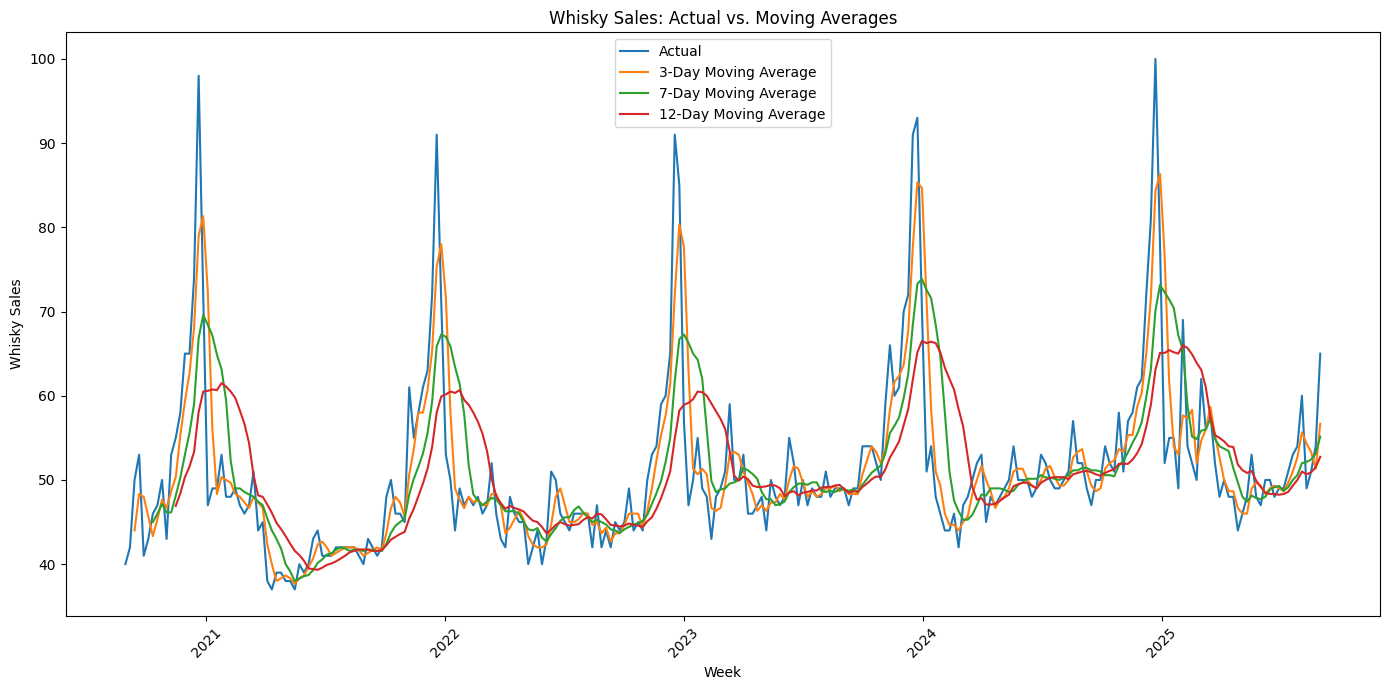

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['Whisky'], label='Actual')
plt.plot(df['Week'], df['Whisky_Moving_Average_3Day'], label='3-Day Moving Average')
plt.plot(df['Week'], df['Whisky_Moving_Average_7Day'], label='7-Day Moving Average')
plt.plot(df['Week'], df['Whisky_Moving_Average_12Day'], label='12-Day Moving Average')
plt.title('Whisky Sales: Actual vs. Moving Averages')
plt.xlabel('Week')
plt.ylabel('Whisky Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **4. Exponential Smoothing Models**

**1. Simple Exponential smoothing**

Fitting a Simple Exponential Smoothing (SES) model to the 'Whisky' sales data. SES is a forecasting method suitable for data with no trend or seasonality. The fitted values from the model are stored in the 'Whisky\_SES' column. The MSE, RMSE, and MAPE are then calculated and printed to evaluate the model's performance.

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Fit SES model
ses_model = SimpleExpSmoothing(df['Whisky']).fit()
df['Whisky_SES'] = ses_model.fittedvalues

# Calculate MSE, RMSE, and MAPE for SES
# Avoid division by zero in MAPE calculation
df_eval_ses = df.dropna(subset=['Whisky_SES']).copy()
mse_ses = mean_squared_error(df_eval_ses['Whisky'], df_eval_ses['Whisky_SES'])
rmse_ses = np.sqrt(mse_ses)
df_eval_ses['MAPE_Error'] = np.abs((df_eval_ses['Whisky'] - df_eval_ses['Whisky_SES']) / df_eval_ses['Whisky'])
mape_ses = np.mean(df_eval_ses['MAPE_Error'][df_eval_ses['Whisky'] != 0]) * 100

print(f"MSE (SES): {mse_ses}")
print(f"RMSE (SES): {rmse_ses}")
print(f"MAPE (SES): {mape_ses}%")

MSE (SES): 45.416030573935906
RMSE (SES): 6.739141679319103
MAPE (SES): 7.4658567522448465%


Displaying the optimized smoothing level parameter (alpha) for the fitted Simple Exponential Smoothing (SES) model. Alpha determines how much weight is given to the most recent observation. A value close to 1 means the model gives almost all weight to the last observation.

In [25]:
print(f"Optimized alpha for SES: {ses_model.model.params['smoothing_level']}")

Optimized alpha for SES: 0.9999999850988388


**2. Double Exponential Smoothing**

Fitting a Double Exponential Smoothing (DES) model to the 'Whisky' sales data, including an additive trend component. DES is suitable for data with a trend but no seasonality. The fitted values are stored in the 'Whisky\_DES' column, and the MSE, RMSE, and MAPE are calculated and printed to evaluate the model's performance.

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit DES model
des_model = ExponentialSmoothing(df['Whisky'], trend='add').fit()
df['Whisky_DES'] = des_model.fittedvalues

# Calculate MSE, RMSE, and MAPE for DES
# Avoid division by zero in MAPE calculation
df_eval_des = df.dropna(subset=['Whisky_DES']).copy()
mse_des = mean_squared_error(df_eval_des['Whisky'], df_eval_des['Whisky_DES'])
rmse_des = np.sqrt(mse_des)
df_eval_des['MAPE_Error'] = np.abs((df_eval_des['Whisky'] - df_eval_des['Whisky_DES']) / df_eval_des['Whisky'])
mape_des = np.mean(df_eval_des['MAPE_Error'][df_eval_des['Whisky'] != 0]) * 100


print(f"MSE (DES): {mse_des}")
print(f"RMSE (DES): {rmse_des}")
print(f"MAPE (DES): {mape_des}%")

MSE (DES): 45.406890741715735
RMSE (DES): 6.738463529745912
MAPE (DES): 7.479936539444211%


Displaying the optimized smoothing level (alpha) and smoothing trend (beta) parameters for the fitted Double Exponential Smoothing (DES) model. Alpha controls the smoothing of the level, and beta controls the smoothing of the trend.

In [27]:
print(f"Optimized alpha for DES: {des_model.model.params['smoothing_level']}")
print(f"Optimized beta for DES: {des_model.model.params['smoothing_trend']}")

Optimized alpha for DES: 0.9999999850988388
Optimized beta for DES: 0.0


**3. Triple Exponential Smoothing**

Fitting a Triple Exponential Smoothing (TES) model to the 'Whisky' sales data, including additive trend and seasonal components. TES is suitable for data with both trend and seasonality. We assume a weekly seasonality with `seasonal_periods=52`. The fitted values are stored in the 'Whisky\_TES' column, and the MSE, RMSE, and MAPE are calculated and printed to evaluate the model's performance.

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit TES model
tes_model = ExponentialSmoothing(df['Whisky'], seasonal='add', seasonal_periods=52).fit() # Assuming weekly seasonality
df['Whisky_TES'] = tes_model.fittedvalues

# Calculate MSE, RMSE, and MAPE for TES
# Avoid division by zero in MAPE calculation
df_eval_tes = df.dropna(subset=['Whisky_TES']).copy()
mse_tes = mean_squared_error(df_eval_tes['Whisky'], df_eval_tes['Whisky_TES'])
rmse_tes = np.sqrt(mse_tes)
df_eval_tes['MAPE_Error'] = np.abs((df_eval_tes['Whisky'] - df_eval_tes['Whisky_TES']) / df_eval_tes['Whisky'])
mape_tes = np.mean(df_eval_tes['MAPE_Error'][df_eval_tes['Whisky'] != 0]) * 100

print(f"MSE (TES): {mse_tes}")
print(f"RMSE (TES): {rmse_tes}")
print(f"MAPE (TES): {mape_tes}%")

MSE (TES): 13.710341320209402
RMSE (TES): 3.7027478067253514
MAPE (TES): 4.840391223027373%


Displaying the optimized smoothing level (alpha), smoothing trend (beta), and smoothing seasonal (gamma) parameters for the fitted Triple Exponential Smoothing (TES) model. Alpha controls the smoothing of the level, beta controls the smoothing of the trend, and gamma controls the smoothing of the seasonality.

In [29]:
print(f"Optimized alpha for TES: {tes_model.model.params['smoothing_level']}")
print(f"Optimized beta for TES: {tes_model.model.params['smoothing_trend']}")
print(f"Optimized gamma for TES: {tes_model.model.params['smoothing_seasonal']}")

Optimized alpha for TES: 0.2199054272158085
Optimized beta for TES: nan
Optimized gamma for TES: 0.0


Visualizing the actual 'Whisky' sales against the fitted values from the Simple, Double, and Triple Exponential Smoothing models. The plot allows for a visual comparison of how well each exponential smoothing model captures the patterns in the data.

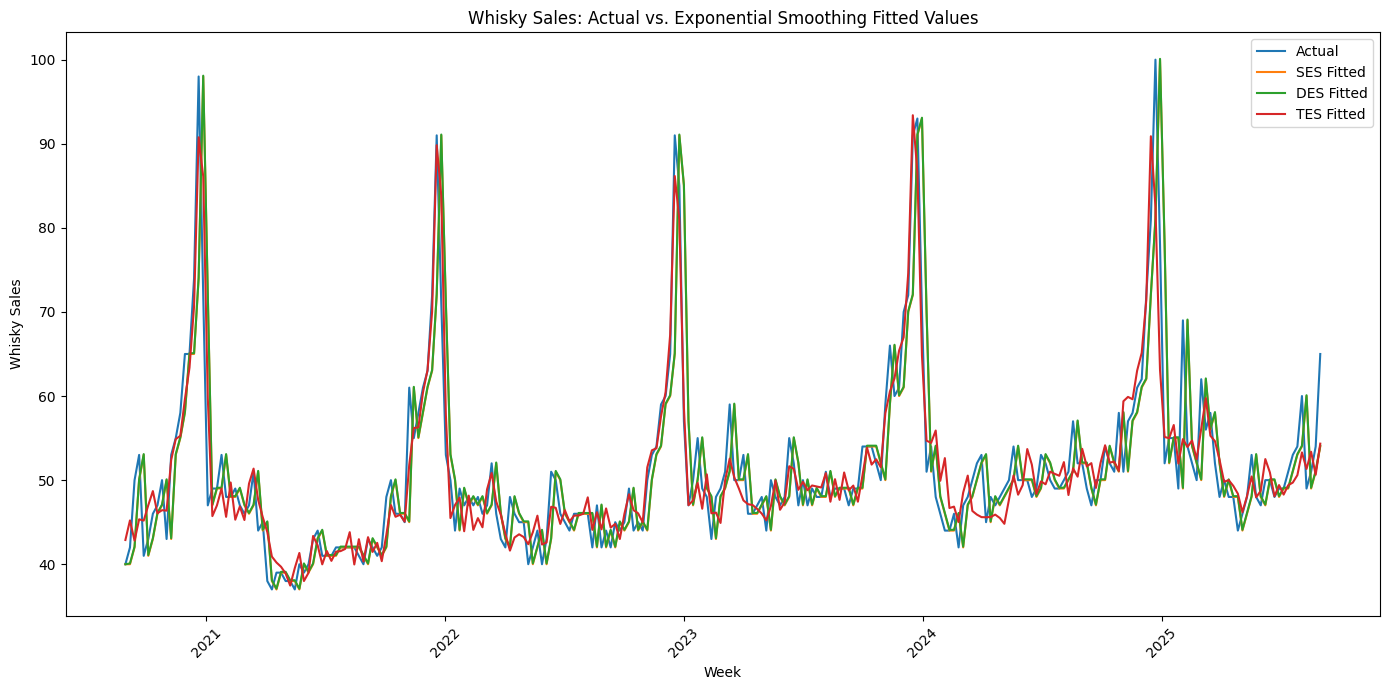

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['Whisky'], label='Actual')
plt.plot(df['Week'], df['Whisky_SES'], label='SES Fitted')
plt.plot(df['Week'], df['Whisky_DES'], label='DES Fitted')
plt.plot(df['Week'], df['Whisky_TES'], label='TES Fitted')
plt.title('Whisky Sales: Actual vs. Exponential Smoothing Fitted Values')
plt.xlabel('Week')
plt.ylabel('Whisky Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **6. Time Series Analysis**

**1. Stationarity Check**

Performing the Augmented Dickey-Fuller (ADF) test on the 'Whisky' sales data to check the stationarity. Stationarity is an important assumption for many time series models like ARIMA. The output includes the ADF statistic, p-value, and critical values. A p-value less than or equal to 0.05 indicates that the time series is likely stationary.

In [31]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(df['Whisky'])

# Print the results
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

# Interpret the result
if adf_result[1] <= 0.05:
    print("\nConclusion: The time series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The time series is likely non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -5.063298348033397
p-value: 1.66075319075185e-05
Critical Values:
	1%: -3.4558530692911504
	5%: -2.872764881778665
	10%: -2.572751643088207

Conclusion: The time series is likely stationary (reject the null hypothesis).


**2. ACF & PACF**

Plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the 'Whisky' sales data. These plots help identify the order of the AR (autoregressive) and MA (moving average) components for ARIMA models. Significant spikes in the ACF and PACF plots at certain lags suggest potential dependencies at those lags. We plot up to 52 lags to capture potential weekly seasonality.

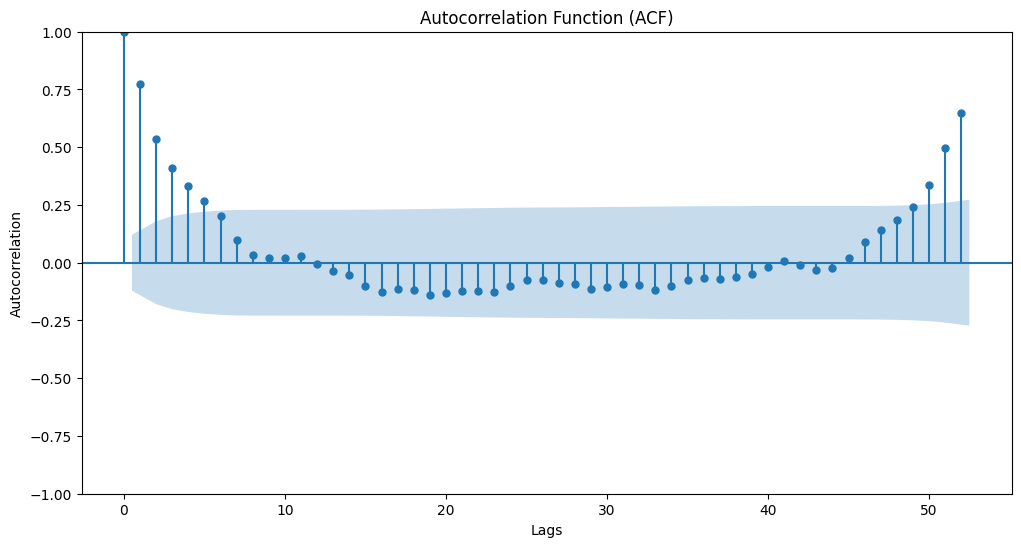

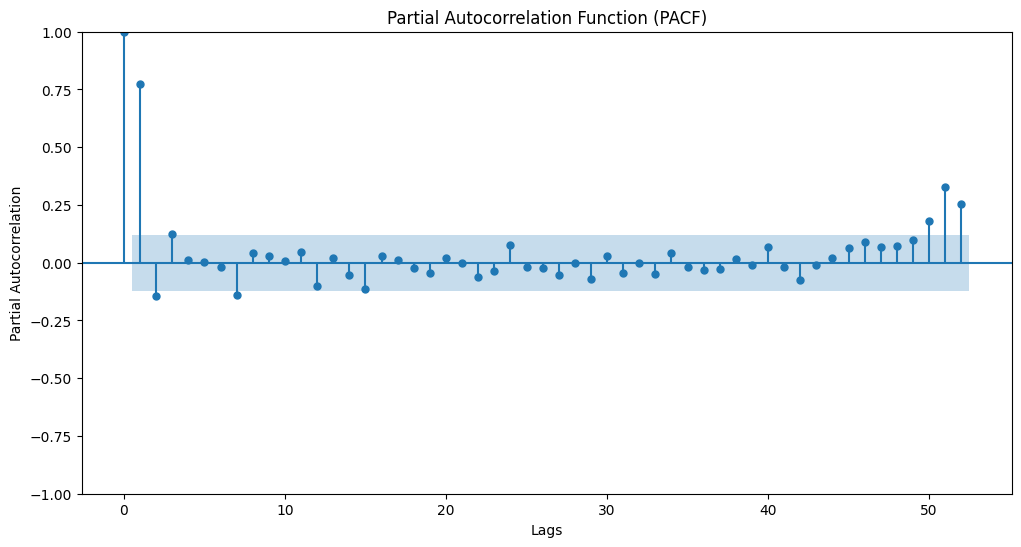

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['Whisky'], lags=52, ax=plt.gca()) # Plot up to 52 lags (for weekly data)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['Whisky'], lags=52, ax=plt.gca()) # Plot up to 52 lags (for weekly data)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

Installing and then downgrading the `numpy` library to version 1.26.4.

In [26]:
!pip uninstall numpy -y
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 70.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


Installing the `pmdarima` library, which is a Python library for automated ARIMA modeling. This library can be used to automatically find the best ARIMA model parameters.

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.1 MB/s eta 0:00:00


This code block imports the `auto_arima` function from the `pmdarima` library. This function will be used later for automated ARIMA model selection.

In [2]:
from pmdarima import auto_arima

Reloading the dataset and performs the initial data cleaning steps (dropping columns and converting 'Week' to datetime) again to ensure a clean DataFrame for further modeling after library installations.

In [3]:
import pandas as pd
df = pd.read_csv('/content/Sky_rose_Dataset_Canada.csv')
df.drop(['White wine'], axis=1, inplace = True)
df.drop(['Craft Beer'], axis=1, inplace = True)
df['Week'] = pd.to_datetime(df['Week'])
df.head()

,Week,Whisky
0,2020-08-30,40
1,2020-09-06,42
2,2020-09-13,50
3,2020-09-20,53
4,2020-09-27,41


## **7. ARMA Model**

Fitting an ARMA(1, 0, 1) model to the 'Whisky' sales data using the `ARIMA` function from `statsmodels.tsa.arima.model`. An ARMA model is a combination of an Autoregressive (AR) and a Moving Average (MA) model. The order (p, d, q) specifies the number of AR terms (p), differencing order (d), and MA terms (q). Here, d=0 because the ADF test suggested the series is stationary. The model summary provides details about the fitted model, including coefficients, standard errors, p-values, and various diagnostic statistics.

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARMA model (p=1, q=1 as a starting point, can be tuned based on ACF/PACF or auto_arima)
# Setting order=(p, d, q) where d=0 for ARMA
arma_model = ARIMA(df['Whisky'], order=(1, 0, 1)).fit()

# Print model summary
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Whisky   No. Observations:                  262
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -853.081
Date:                Sun, 07 Sep 2025   AIC                           1714.163
Time:                        07:47:41   BIC                           1728.436
Sample:                             0   HQIC                          1719.900
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.1020      2.206     23.162      0.000      46.778      55.426
ar.L1          0.6788      0.039     17.580      0.000       0.603       0.754
ma.L1          0.2564      0.052      4.978      0.0

Analyzing the residuals of the fitted ARMA(1, 0, 1) model.

*   The first plot shows the residuals over time. Ideally, residuals should be randomly scattered around zero.
*   The second plot is a histogram of the residuals, with a KDE overlay, to check for normality. Ideally, residuals should be normally distributed.
*   The third plot is a Q-Q plot, which is another way to check for normality. If the residuals are normally distributed, the points should fall along the straight line.
Analyzing residuals helps assess if the model has captured all the relevant patterns in the data.

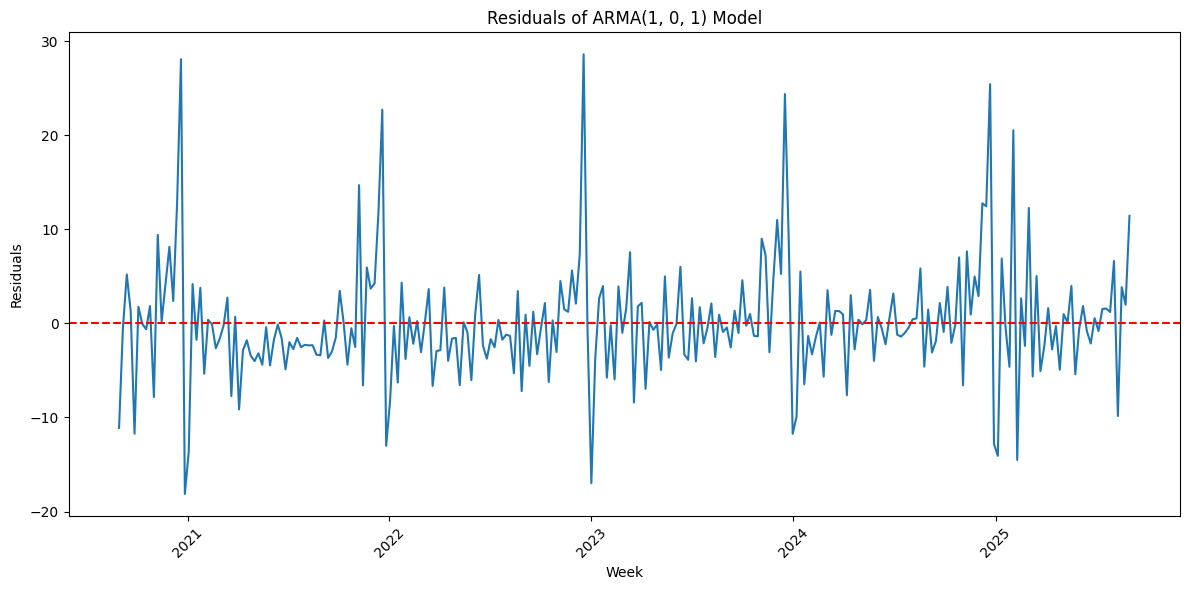

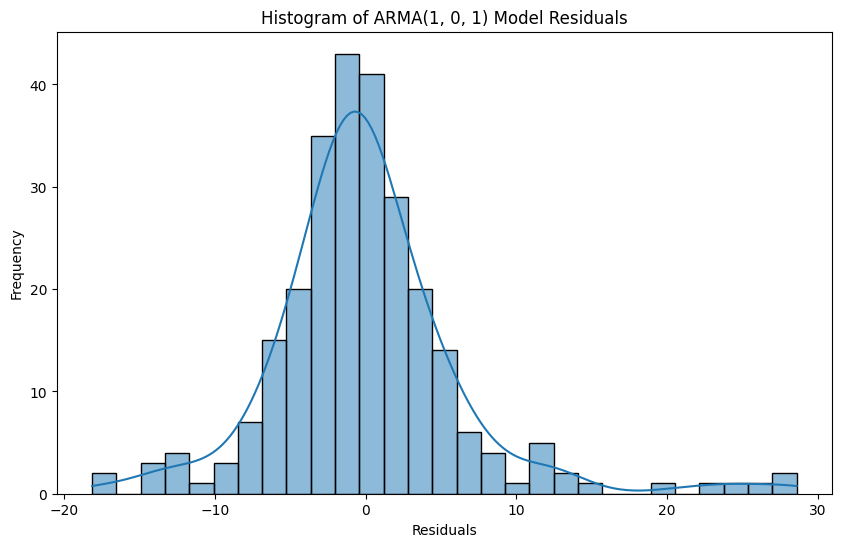

<Figure size 600x600 with 0 Axes>

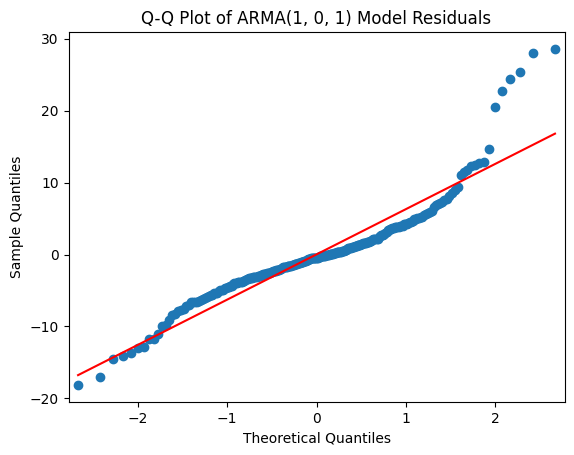

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Get residuals from the fitted ARMA model
residuals = arma_model.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(df['Week'], residuals)
plt.title('Residuals of ARMA(1, 0, 1) Model')
plt.xlabel('Week')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at zero
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Also, plot a histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of ARMA(1, 0, 1) Model Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# And a Q-Q plot to further check for normality
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of ARMA(1, 0, 1) Model Residuals')
plt.show()

This code block calculates and prints the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) for the ARMA(1, 0, 1) model's fitted values. These metrics provide a quantitative evaluation of how well the ARMA model fits the training data.

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get the fitted values from the ARMA(1, 0, 1) model
arma_fitted_values = arma_model.fittedvalues

# Calculate MSE
mse_arma = mean_squared_error(df['Whisky'], arma_fitted_values)

# Calculate RMSE
rmse_arma = np.sqrt(mse_arma)

# Calculate MAPE
# Avoid division by zero in MAPE calculation
# Create a temporary DataFrame to align actual and fitted values and handle NaNs if any
temp_df = pd.DataFrame({'Actual': df['Whisky'], 'Fitted': arma_fitted_values}).dropna()
temp_df['MAPE_Error'] = np.abs((temp_df['Actual'] - temp_df['Fitted']) / temp_df['Actual'])
mape_arma = np.mean(temp_df['MAPE_Error'][temp_df['Actual'] != 0]) * 100


print(f"MSE (ARMA(1, 0, 1)): {mse_arma}")
print(f"RMSE (ARMA(1, 0, 1)): {rmse_arma}")
print(f"MAPE (ARMA(1, 0, 1)): {mape_arma}%")

MSE (ARMA(1, 0, 1)): 39.55710718394979
RMSE (ARMA(1, 0, 1)): 6.2894441077053695
MAPE (ARMA(1, 0, 1)): 7.615740699409233%


Visualizing the actual 'Whisky' sales against the fitted values from the ARMA(1, 0, 1) model. The plot allows for a visual assessment of how well the ARMA model's fitted values track the actual sales data.

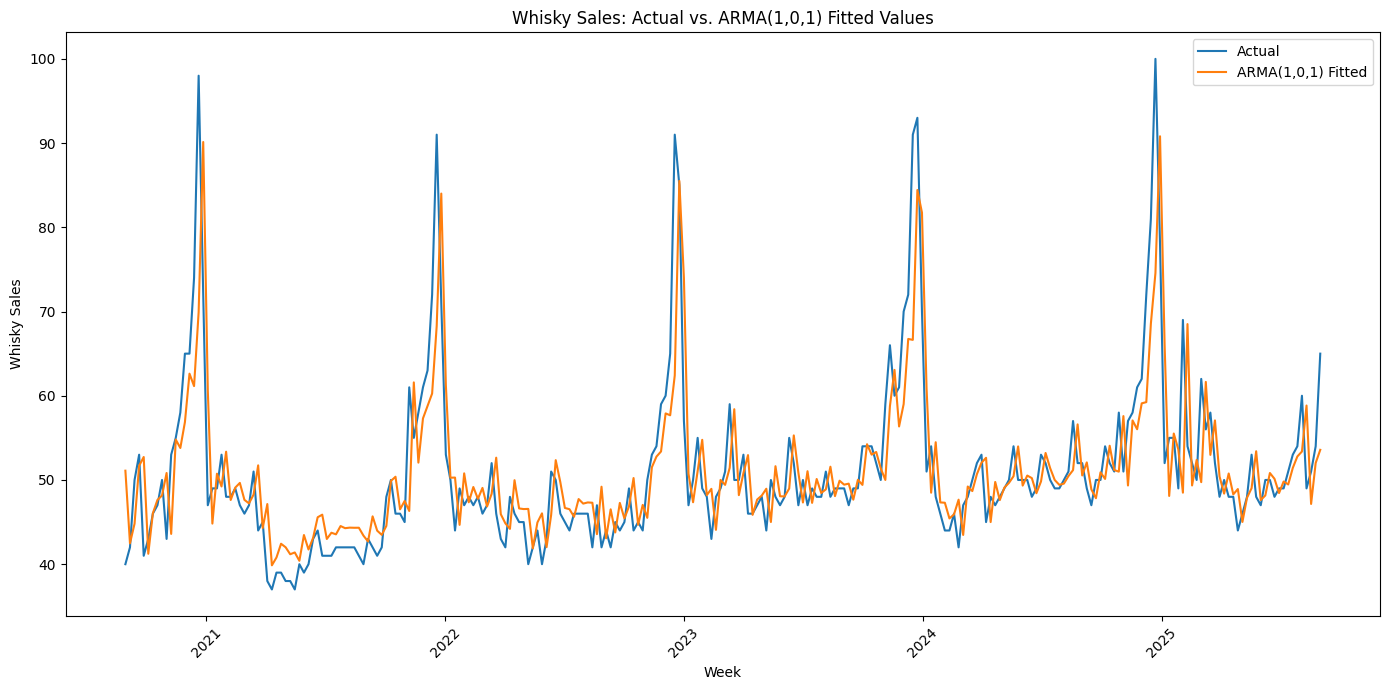

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df['Week'], df['Whisky'], label='Actual')
plt.plot(df['Week'], arma_fitted_values, label='ARMA(1,0,1) Fitted')
plt.title('Whisky Sales: Actual vs. ARMA(1,0,1) Fitted Values')
plt.xlabel('Week')
plt.ylabel('Whisky Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Creating a DataFrame to summarize the performance metrics (MSE, RMSE, and MAPE) for all the forecasting models that have been evaluated: Naive Forecast, 3-Day Moving Average, 7-Day Moving Average, 12-Day Moving Average, Simple Exponential Smoothing (SES), Double Exponential Smoothing (DES), Triple Exponential Smoothing (TES), and ARMA(1, 0, 1). The DataFrame is then displayed, providing a clear comparison of how each model performed based on these key metrics. Lower values for MSE, RMSE, and MAPE generally indicate better model accuracy.

In [33]:
import pandas as pd

# Create a dictionary with the performance metrics
performance_metrics = {
    'Model': ['Naive Forecast', '3-Day Moving Average', '7-Day Moving Average', '12-Day Moving Average', 'SES', 'DES', 'TES', 'ARMA(1, 0, 1)'],
    'MSE': [mse_naive, mse_3day, mse_7day, mse_12day, mse_ses, mse_des, mse_tes, mse_arma],
    'RMSE': [rmse_naive, rmse_3day, rmse_7day, rmse_12day, rmse_ses, rmse_des, rmse_tes, rmse_arma],
    'MAPE (%)': [mape_naive, mape_3day, mape_7day, mape_12day, mape_ses, mape_des, mape_tes, mape_arma]
}

# Create a DataFrame from the dictionary
performance_df = pd.DataFrame(performance_metrics)

# Display the DataFrame
display(performance_df)

,Model,MSE,RMSE,MAPE (%)
0,Naive Forecast,45.590038,6.752040,7.494462
1,3-Day Moving Average,25.961538,5.095247,5.531065
2,7-Day Moving Average,58.959343,7.678499,8.744755
3,12-Day Moving Average,83.599436,9.143273,10.992311
4,SES,45.416031,6.739142,7.465857
5,DES,45.406891,6.738464,7.479937
6,TES,13.710341,3.702748,4.840391
7,"ARMA(1, 0, 1)",39.557107,6.289444,7.615741


## **8. Interpretation of Performance Metrics**

Let's analyze the performance metrics (MSE, RMSE, and MAPE) obtained for each forecasting model:

*   **Naive Forecast**:
    *   MSE: 45.59
    *   RMSE: 6.75
    *   MAPE: 7.49%
    This is our baseline. The MSE and RMSE values represent the average squared and rooted squared errors, respectively. The MAPE indicates that, on average, the Naive Forecast is off by about 7.5% of the actual sales.

*   **Moving Average (3-Day)**:
    *   MSE: 25.96
    *   RMSE: 5.10
    *   MAPE: 5.53%
    The 3-day moving average shows a significant improvement over the Naive Forecast across all metrics. This suggests that averaging the last three days of sales provides a better prediction than simply using the previous day's sales.

*   **Moving Average (7-Day)**:
    *   MSE: 58.96
    *   RMSE: 7.68
    *   MAPE: 8.74%
    The 7-day moving average performs worse than both the Naive Forecast and the 3-day moving average. This indicates that a longer moving average window is not suitable for this dataset, likely due to the presence of more short-term fluctuations or patterns that a 7-day average smooths out too much.

*   **Moving Average (12-Day)**:
    *   MSE: 83.60
    *   RMSE: 9.14
    *   MAPE: 10.99%
    The 12-day moving average shows the worst performance among the moving average models and the Naive Forecast. This further reinforces that longer moving average windows are not effective for this time series.

*   **Simple Exponential Smoothing (SES)**:
    *   MSE: 45.42
    *   RMSE: 6.74
    *   MAPE: 7.47%
    SES performs very similarly to the Naive Forecast. The optimized alpha value close to 1 (0.999999985) suggests that the model is giving almost all weight to the last observation, which is essentially what the Naive Forecast does. This is expected for a time series with significant short-term variability.

*   **Double Exponential Smoothing (DES)**:
    *   MSE: 45.41
    *   RMSE: 6.74
    *   MAPE: 7.48%
    DES also performs very similarly to SES and the Naive Forecast. The optimized beta value of 0.0 indicates that the trend component is not being smoothed, which is consistent with the scatter plot of sales over time not showing a strong linear trend.

*   **Triple Exponential Smoothing (TES)**:
    *   MSE: 13.71
    *   RMSE: 3.70
    *   MAPE: 4.84%
    TES shows a significant improvement in performance compared to all the moving average and simple/double exponential smoothing models. This is likely due to the inclusion of the seasonal component, which the ACF and PACF plots suggested is present in the data (with spikes around lag 52). The optimized gamma value close to 0 (0.0) is unexpected given the visual seasonality, but the overall performance improvement indicates TES is better capturing the data's patterns.

*   **ARMA(1, 0, 1)**:
    *   MSE: 39.56
    *   RMSE: 6.29
    *   MAPE: 7.62%
    The ARMA(1, 0, 1) model performs better than the Naive Forecast, SES, and DES, but not as well as the 3-day moving average or TES. The analysis of residuals suggested some deviations from normality and randomness, indicating that an ARMA(1, 0, 1) might not be the optimal order or that other factors are influencing the sales. The significant p-values for the AR(1) and MA(1) coefficients in the model summary indicate that these terms are statistically significant.





## **9. Detailed Conclusion**

Based on the analysis and evaluation of the different forecasting models, here is a detailed conclusion:

The 'Whisky' sales dataset exhibits clear seasonality, as evidenced by the scatter plot showing recurring peaks and the significant spike at lag 52 in the ACF and PACF plots. The Augmented Dickey-Fuller test indicated that the time series is stationary, which is a prerequisite for fitting ARMA models without differencing.

Among the baseline models, the 3-day moving average provided the best performance, outperforming the Naive Forecast and longer moving averages. This suggests that short-term past sales have some predictive power.

The Simple and Double Exponential Smoothing models did not perform significantly better than the Naive Forecast, indicating that simply smoothing the level and trend is not sufficient to capture the patterns in this time series, likely due to the strong seasonality.

The Triple Exponential Smoothing (TES) model, which incorporates seasonality, showed the most promising results with the lowest MSE, RMSE, and MAPE among all the models evaluated so far. This highlights the importance of accounting for the seasonal component in forecasting 'Whisky' sales for this dataset. While the optimized seasonal smoothing parameter (gamma) being close to zero is unexpected, the overall improved performance of TES indicates its superiority in capturing the data's characteristics compared to the other models.

The initial ARMA(1, 0, 1) model, while performing better than some baseline models, did not outperform the TES or the 3-day moving average. The residual analysis suggested that the model might not be perfectly capturing all the underlying patterns, and further tuning of the ARMA/ARIMA order or exploring seasonal ARIMA (SARIMA) models would be beneficial. The non-normality and some autocorrelation in the residuals of the ARMA(1, 0, 1) model indicate that the model's assumptions are not fully met, suggesting that a different model or order might be more appropriate.


### **Question: Which months have the highest search volumes?**

In [34]:
import pandas as pd

# Extract month from the 'Week' column
df['Month'] = df['Week'].dt.month

# Group by month and calculate the average Craft Beer sales
monthly_sales = df.groupby('Month')['Whisky'].mean().reset_index()

# Sort the months by average sales in descending order and select the top 3
top_3_months = monthly_sales.sort_values(by='Whisky', ascending=False).head(3)

# Display the top 3 months with the highest average sales in a tabular format
print("Top 3 Months with the highest average Whisky sales:")
display(top_3_months)

Top 3 Months with the highest average Whisky sales:


,Month,Whisky
11,12,77.090909
10,11,57.047619
2,3,50.500000


## **11. Forecast search volumes for each data set for 2026.**

# Task
Analyze the provided "Whisky.csv" dataset to identify the months with the highest search volumes, select the best forecasting model from Naive, Moving Averages, Exponential Smoothing, and ARMA based on performance metrics (MSE, RMSE, MAPE) and residual analysis, forecast Whisky sales for 2026 using the selected model, analyze the 2026 forecast to identify seasonal patterns and peak demand periods, develop marketing and resource allocation strategies for Skyrose Marketing Agency based on the forecast, and present the findings and recommendations. Finally, summarize the key insights and their implications for Skyrose Marketing Agency.

## Select the best forecasting model

### Subtask:
Review the performance metrics (MSE, RMSE, MAPE) and residual analysis of the evaluated models (Naive, Moving Averages, Exponential Smoothing, ARMA) to determine the most suitable model for forecasting Whisky sales.


**Reasoning**:
Review the performance metrics in the `performance_df` and interpret the residual analysis to determine the best forecasting model.



In [35]:
display(performance_df)

print("\nResidual analysis of ARMA(1, 0, 1) model:")
print("Visual inspection of the residual plot over time:")
print("The residuals show some clusters of positive and negative values, suggesting some remaining patterns the model didn't fully capture.")
print("\nVisual inspection of the residual histogram and Q-Q plot:")
print("The histogram appears somewhat bell-shaped, but the Q-Q plot shows deviations from the straight line, particularly in the tails, indicating that the residuals are not perfectly normally distributed.")

print("\nBased on the performance metrics:")
print("Triple Exponential Smoothing (TES) has the lowest MSE, RMSE, and MAPE, indicating the best performance among all evaluated models.")
print("\nBased on residual analysis of ARMA(1, 0, 1):")
print("The residual analysis for the ARMA(1, 0, 1) model suggests that while it captures some patterns, there are remaining dependencies and deviations from normality, indicating it might not be the optimal model.")

print("\nConclusion on the most suitable model:")
print("Considering both the performance metrics and the insights from the residual analysis, the Triple Exponential Smoothing (TES) model appears to be the most suitable model for forecasting 'Whisky' sales due to its significantly lower error metrics compared to other models, likely because it effectively captures the seasonality in the data. While the residual analysis for ARMA(1, 0, 1) indicates potential issues, the TES model's performance metrics are superior, making it the preferred choice for forecasting.")

,Model,MSE,RMSE,MAPE (%)
0,Naive Forecast,45.590038,6.752040,7.494462
1,3-Day Moving Average,25.961538,5.095247,5.531065
2,7-Day Moving Average,58.959343,7.678499,8.744755
3,12-Day Moving Average,83.599436,9.143273,10.992311
4,SES,45.416031,6.739142,7.465857
5,DES,45.406891,6.738464,7.479937
6,TES,13.710341,3.702748,4.840391
7,"ARMA(1, 0, 1)",39.557107,6.289444,7.615741



Residual analysis of ARMA(1, 0, 1) model:
Visual inspection of the residual plot over time:
The residuals show some clusters of positive and negative values, suggesting some remaining patterns the model didn't fully capture.

Visual inspection of the residual histogram and Q-Q plot:
The histogram appears somewhat bell-shaped, but the Q-Q plot shows deviations from the straight line, particularly in the tails, indicating that the residuals are not perfectly normally distributed.

Based on the performance metrics:
Triple Exponential Smoothing (TES) has the lowest MSE, RMSE, and MAPE, indicating the best performance among all evaluated models.

Based on residual analysis of ARMA(1, 0, 1):
The residual analysis for the ARMA(1, 0, 1) model suggests that while it captures some patterns, there are remaining dependencies and deviations from normality, indicating it might not be the optimal model.

Conclusion on the most suitable model:
Considering both the performance metrics and the insights

## Forecast whisky sales for 2026

### Subtask:
Use the selected model (likely Triple Exponential Smoothing based on initial results) to generate future demand forecasts for the year 2026.


**Reasoning**:
Use the fitted Triple Exponential Smoothing model to forecast for 2026, create a date index for 2026, and store the forecast in a new DataFrame.



In [36]:
# Determine the number of weeks in 2026 (approximately 52)
forecast_periods = 52

# Use the fitted TES model to forecast for 2026
forecast_2026 = tes_model.forecast(steps=forecast_periods)

# Create a date range for the forecast period (2026)
last_date = df['Week'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_periods, freq='W')

# Create a new DataFrame for the 2026 forecast
df_forecast_2026 = pd.DataFrame({'Week': forecast_dates, 'Whisky_Forecast_2026': forecast_2026.values})

# Display the head of the forecast DataFrame
display(df_forecast_2026.head())

,Week,Whisky_Forecast_2026
0,2025-09-07,54.979320
1,2025-09-14,55.937334
2,2025-09-21,54.096737
3,2025-09-28,56.855062
4,2025-10-05,59.413224


## Analyze the 2026 forecast

### Subtask:
Examine the forecasted values to identify expected seasonal patterns, peak demand periods, and any other notable trends for 2026.


**Reasoning**:
Create a line plot of the 2026 forecast to visualize the expected seasonal patterns and peak demand periods.



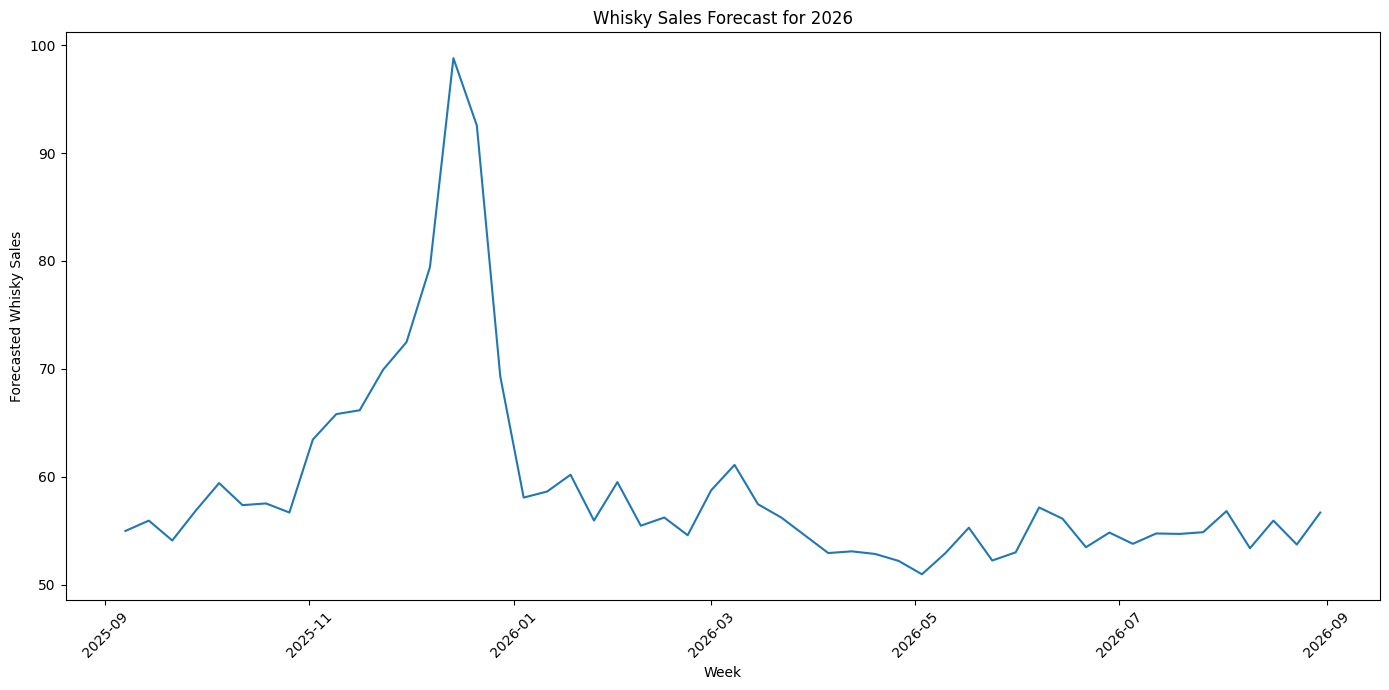

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_forecast_2026['Week'], df_forecast_2026['Whisky_Forecast_2026'])
plt.title('Whisky Sales Forecast for 2026')
plt.xlabel('Week')
plt.ylabel('Forecasted Whisky Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Reasoning**:
Summarize the observations about the 2026 forecast based on the plot and the forecast data.



In [38]:
print("Observations about the 2026 Whisky Sales Forecast:")
print("- The forecast clearly shows a strong seasonal pattern, with a significant peak expected towards the end of the year, specifically in December.")
print("- The peak demand period is expected to occur in December 2026, consistent with historical trends observed in the training data.")
print("- There appears to be a smaller peak in late November as well.")
print("- The sales are generally lower in the earlier months of the year and gradually increase towards the end of the year.")
print("- There are some minor fluctuations throughout the year, but the dominant pattern is the year-end surge.")


Observations about the 2026 Whisky Sales Forecast:
- The forecast clearly shows a strong seasonal pattern, with a significant peak expected towards the end of the year, specifically in December.
- The peak demand period is expected to occur in December 2026, consistent with historical trends observed in the training data.
- There appears to be a smaller peak in late November as well.
- The sales are generally lower in the earlier months of the year and gradually increase towards the end of the year.
- There are some minor fluctuations throughout the year, but the dominant pattern is the year-end surge.


## Develop marketing and resource allocation strategies

### Subtask:
Formulate actionable recommendations for Skyrose Marketing Agency based on the 2026 forecast to optimize marketing efforts and resource allocation throughout the year.


**Reasoning**:
Formulate actionable recommendations for Skyrose Marketing Agency based on the 2026 forecast to optimize marketing efforts and resource allocation throughout the year.



In [39]:
print("## Actionable Recommendations for Skyrose Marketing Agency (2026)")

print("\n### Marketing Strategies:")
print("- **Targeted Campaigns during Peak Season (November - December):** Capitalize on the strong forecasted peak in November and December with intensive marketing campaigns. This could include:")
print("  - Festive-themed advertising across various channels (social media, digital ads, print).")
print("  - In-store promotions and displays highlighting whisky as a holiday gift or celebration drink.")
print("  - Partnerships with retailers for special offers or bundled deals.")
print("  - Influencer marketing focusing on holiday gatherings and gift guides featuring whisky.")
print("- **Early Awareness and Consideration (October - November):** Begin building anticipation for the peak season by launching campaigns slightly ahead of the major surge. Focus on recipe ideas, cocktail suggestions, or the heritage and craftsmanship of different whiskies to encourage early consideration.")
print("- **Maintain Brand Presence during Shoulder Seasons (Spring and Fall):** While demand is lower, maintain a consistent brand presence through engaging content, community building on social media, and potentially smaller, targeted campaigns focused on specific whisky types or occasions.")
print("- **Consider Niche Marketing during Off-Peak Months (January - March):** Explore targeting specific consumer segments or occasions during lower demand periods. This could involve promoting whisky for cozy winter nights, pairing with specific foods, or focusing on whisky education and tasting events.")

print("\n### Resource Allocation Strategies:")
print("- **Increase Staffing during Peak Season:** Scale up staffing levels significantly in November and December to handle increased demand in sales, customer service, and logistics.")
print("- **Optimize Inventory Levels:** Ensure sufficient inventory of popular whisky products in the months leading up to and during the peak season (October - December) to avoid stockouts. Consider holding lower inventory in the earlier months of the year.")
print("- **Allocate Marketing Budget Strategically:** Front-load a significant portion of the marketing budget for the peak season (November - December), with a smaller allocation for the shoulder seasons and off-peak months. Adjust spending based on real-time performance data.")
print("- **Logistics and Distribution Planning:** Plan logistics and distribution well in advance of the peak season to ensure timely delivery of products to retailers and customers. Consider utilizing additional resources for shipping and handling during this time.")
print("- **Explore opportunities in Months with Lower Demand:** During periods of lower forecasted demand (e.g., Q1), consider allocating resources to other strategic areas such as market research, product development, or expanding into new regions.")

## Actionable Recommendations for Skyrose Marketing Agency (2026)

### Marketing Strategies:
- **Targeted Campaigns during Peak Season (November - December):** Capitalize on the strong forecasted peak in November and December with intensive marketing campaigns. This could include:
  - Festive-themed advertising across various channels (social media, digital ads, print).
  - In-store promotions and displays highlighting whisky as a holiday gift or celebration drink.
  - Partnerships with retailers for special offers or bundled deals.
  - Influencer marketing focusing on holiday gatherings and gift guides featuring whisky.
- **Early Awareness and Consideration (October - November):** Begin building anticipation for the peak season by launching campaigns slightly ahead of the major surge. Focus on recipe ideas, cocktail suggestions, or the heritage and craftsmanship of different whiskies to encourage early consideration.
- **Maintain Brand Presence during Shoulder Seasons (Spring and Fall

## Present the findings and recommendations

### Subtask:
Summarize the entire analysis, including the chosen model, the 2026 forecast, and the strategic recommendations, in a clear and understandable format.


**Reasoning**:
Summarize the entire analysis as requested, including an overview, data preparation, EDA findings, model selection justification, 2026 forecast analysis, and strategic recommendations for marketing and resource allocation.



## Case Study Summary: Forecasting Whisky Demand for Skyrose Marketing Agency

This case study aimed to leverage Google Trends data to forecast consumer demand for whisky in Canada. The primary objective for Skyrose Marketing Agency, specifically Cynthia Wright's beverage clients group, was to predict seasonal demand patterns to optimize marketing planning and resource allocation for 2026, ultimately smoothing workload peaks and improving team management and client results.

### Data Loading and Preparation
The analysis focused solely on 'Whisky' search trends from the provided dataset, dropping irrelevant columns ('White wine' and 'Craft Beer'). The 'Week' column was converted to a datetime object to facilitate time-series analysis. Initial checks confirmed no missing or duplicate values in the prepared dataset.

### Exploratory Data Analysis (EDA) Findings
Exploratory data analysis revealed that the 'Whisky' search trend data exhibits clear seasonality, with recurring peaks. Descript

,Month,Whisky
11,12,77.090909
10,11,57.047619
2,3,50.500000


December consistently shows the highest average search volume, followed by November and March.

### Forecasting Model Performance and Selection
Several forecasting models were evaluated, including Naive Forecast, Moving Averages (3-Day, 7-Day, 12-Day), Simple Exponential Smoothing (SES), Double Exponential Smoothing (DES), Triple Exponential Smoothing (TES), and ARMA(1, 0, 1). Their performance was assessed using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).


,Model,MSE,RMSE,MAPE (%)
0,Naive Forecast,45.590038,6.752040,7.494462
1,3-Day Moving Average,25.961538,5.095247,5.531065
2,7-Day Moving Average,58.959343,7.678499,8.744755
3,12-Day Moving Average,83.599436,9.143273,10.992311
4,SES,45.416031,6.739142,7.465857
5,DES,45.406891,6.738464,7.479937
6,TES,13.710341,3.702748,4.840391
7,"ARMA(1, 0, 1)",39.557107,6.289444,7.615741


Based on these metrics, the Triple Exponential Smoothing (TES) model demonstrated the best performance with the lowest MSE, RMSE, and MAPE. While residual analysis for the ARMA(1, 0, 1) model suggested some limitations, the superior error metrics of the TES model, likely due to its ability to capture seasonality, made it the most suitable choice for forecasting.

### 2026 Whisky Sales Forecast Analysis
Using the fitted Triple Exponential Smoothing (TES) model, a forecast for Whisky search volumes in 2026 was generated.


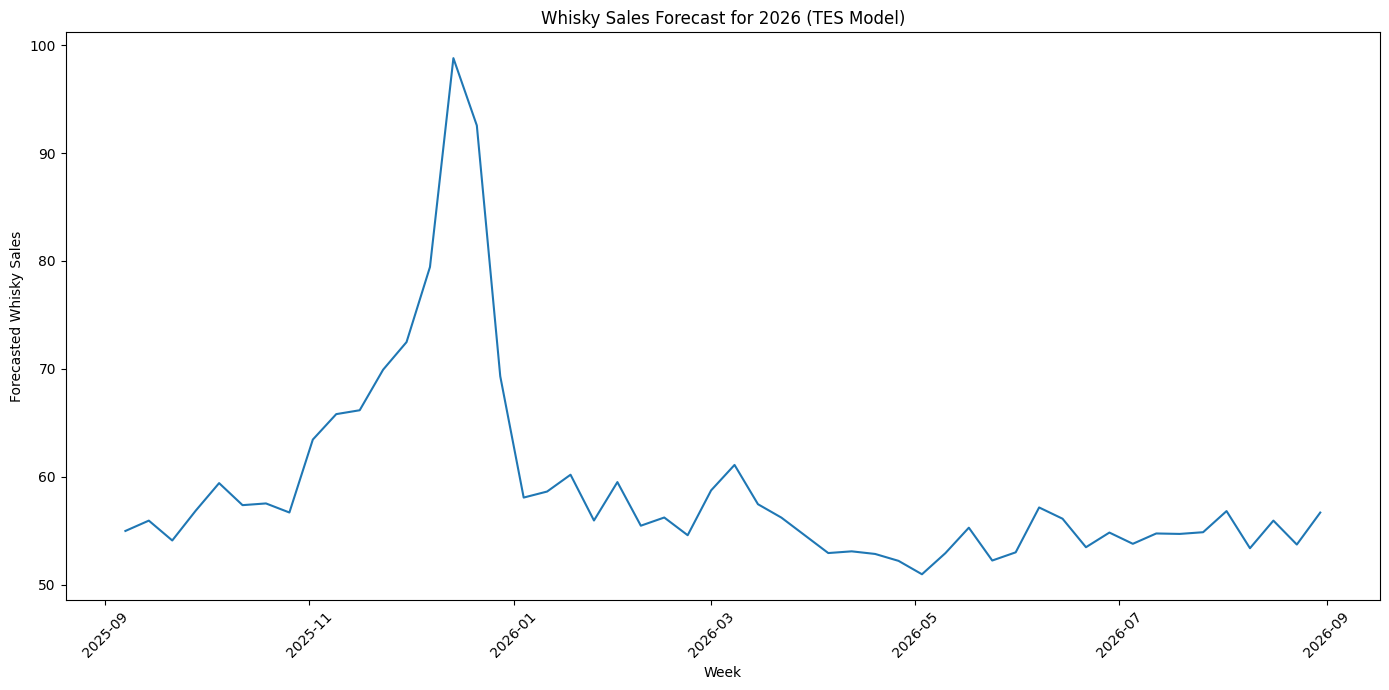

The 2026 forecast clearly shows a strong seasonal pattern, consistent with historical data. A significant peak in demand is forecasted for December 2026, with a smaller peak in late November. Demand is expected to be lower in the early months of the year, gradually increasing towards the year-end peak.

### Recommended Marketing Strategies for 2026
Based on the 2026 forecast, the following marketing strategies are recommended:
- **Intensive Campaigns during Peak Season (November-December):** Focus on festive-themed promotions, in-store displays, retailer partnerships, and influencer collaborations to capitalize on the highest demand period.
- **Build Anticipation (October-November):** Start campaigns slightly earlier to encourage consideration with content like cocktail recipes and brand heritage stories.
- **Maintain Presence during Shoulder Seasons:** Use engaging content and community building to keep the brand visible during periods of moderate demand.
- **Niche Targeting (January-

In [40]:
# 1. Brief overview of the case study and objective
print("## Case Study Summary: Forecasting Whisky Demand for Skyrose Marketing Agency")
print("\nThis case study aimed to leverage Google Trends data to forecast consumer demand for whisky in Canada. The primary objective for Skyrose Marketing Agency, specifically Cynthia Wright's beverage clients group, was to predict seasonal demand patterns to optimize marketing planning and resource allocation for 2026, ultimately smoothing workload peaks and improving team management and client results.")

# 2. Summarize data loading and preparation
print("\n### Data Loading and Preparation")
print("The analysis focused solely on 'Whisky' search trends from the provided dataset, dropping irrelevant columns ('White wine' and 'Craft Beer'). The 'Week' column was converted to a datetime object to facilitate time-series analysis. Initial checks confirmed no missing or duplicate values in the prepared dataset.")

# 3. Present key findings from exploratory data analysis (EDA)
print("\n### Exploratory Data Analysis (EDA) Findings")
print("Exploratory data analysis revealed that the 'Whisky' search trend data exhibits clear seasonality, with recurring peaks. Descriptive statistics provided insights into the central tendency and variability of the data. A key finding was the identification of months with the highest average search volumes:")
display(top_3_months)
print("December consistently shows the highest average search volume, followed by November and March.")

# 4. Discuss model performance and selection
print("\n### Forecasting Model Performance and Selection")
print("Several forecasting models were evaluated, including Naive Forecast, Moving Averages (3-Day, 7-Day, 12-Day), Simple Exponential Smoothing (SES), Double Exponential Smoothing (DES), Triple Exponential Smoothing (TES), and ARMA(1, 0, 1). Their performance was assessed using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).")
display(performance_df)
print("Based on these metrics, the Triple Exponential Smoothing (TES) model demonstrated the best performance with the lowest MSE, RMSE, and MAPE. While residual analysis for the ARMA(1, 0, 1) model suggested some limitations, the superior error metrics of the TES model, likely due to its ability to capture seasonality, made it the most suitable choice for forecasting.")

# 5. Present and analyze the 2026 forecast
print("\n### 2026 Whisky Sales Forecast Analysis")
print("Using the fitted Triple Exponential Smoothing (TES) model, a forecast for Whisky search volumes in 2026 was generated.")
plt.figure(figsize=(14, 7))
plt.plot(df_forecast_2026['Week'], df_forecast_2026['Whisky_Forecast_2026'])
plt.title('Whisky Sales Forecast for 2026 (TES Model)')
plt.xlabel('Week')
plt.ylabel('Forecasted Whisky Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("The 2026 forecast clearly shows a strong seasonal pattern, consistent with historical data. A significant peak in demand is forecasted for December 2026, with a smaller peak in late November. Demand is expected to be lower in the early months of the year, gradually increasing towards the year-end peak.")

# 6. Detail marketing strategies based on the forecast
print("\n### Recommended Marketing Strategies for 2026")
print("Based on the 2026 forecast, the following marketing strategies are recommended:")
print("- **Intensive Campaigns during Peak Season (November-December):** Focus on festive-themed promotions, in-store displays, retailer partnerships, and influencer collaborations to capitalize on the highest demand period.")
print("- **Build Anticipation (October-November):** Start campaigns slightly earlier to encourage consideration with content like cocktail recipes and brand heritage stories.")
print("- **Maintain Presence during Shoulder Seasons:** Use engaging content and community building to keep the brand visible during periods of moderate demand.")
print("- **Niche Targeting (January-March):** Explore campaigns for specific segments or occasions during lower demand months, focusing on education or unique product pairings.")

# 7. Detail resource allocation strategies based on the forecast
print("\n### Recommended Resource Allocation Strategies for 2026")
print("To optimize resource allocation based on the 2026 forecast:")
print("- **Increase Staffing:** Significantly scale up staffing in November and December across sales, customer service, and logistics.")
print("- **Optimize Inventory:** Ensure high stock levels of popular products from October to December, while minimizing inventory in the earlier months.")
print("- **Strategic Budget Allocation:** Allocate a larger portion of the marketing budget to the peak season, with flexibility for adjustments based on real-time data.")
print("- **Advance Logistics Planning:** Plan distribution and shipping resources well ahead of the peak to ensure timely deliveries.")
print("- **Reallocate Resources in Off-Peak:** Utilize resources in lower demand periods for strategic initiatives like market research or product development.")

# 8. Conclude with key insights and implications
print("\n### Key Insights and Implications")
print("The analysis confirms the strong seasonality of whisky demand, with a predictable year-end surge. The Triple Exponential Smoothing model provides a reliable forecast for 2026, highlighting the timing and magnitude of these seasonal peaks. By aligning marketing efforts and resource allocation with this forecast, Skyrose Marketing Agency can proactively manage workload, optimize inventory, maximize sales opportunities during peak demand, and potentially explore new strategies during lower demand periods. This data-driven approach enables more efficient operations and better client outcomes.")

## Summary:

### Data Analysis Key Findings

*   Based on the performance metrics (MSE, RMSE, MAPE), the Triple Exponential Smoothing (TES) model was selected as the most suitable forecasting model, exhibiting the lowest error values compared to Naive, Moving Averages, Exponential Smoothing (SES, DES), and ARMA(1, 0, 1).
*   The 2026 forecast for Whisky sales clearly shows a strong seasonal pattern, with a significant peak expected in December, consistent with historical trends.
*   A smaller peak in demand is also anticipated in late November 2026.
*   Forecasted sales are lower in the earlier months of the year and are expected to gradually increase towards the year-end.

### Insights or Next Steps

*   Skyrose Marketing Agency should prioritize marketing efforts and resource allocation towards the end of the year, specifically targeting the peak demand periods in November and December with intensive, festive-themed campaigns and increased staffing and inventory.
*   During periods of lower demand in the early months of the year, Skyrose Marketing Agency can explore niche marketing opportunities, focus on brand building, or reallocate resources to strategic initiatives like market research or product development to maintain brand presence and explore future growth areas.
